# Names of the students:
* Omer shik - 318948460
* Rotem Gonen - 318321064

list of intents:

-1 - can't identify

1 - order flight

2 - order taxi

3 - order hotel

4 - number of guests

list of states: 

0 - starting dialog

1 order flight 

2 - order taxi

3 - order hotel 

4 - number of guests

5 - ending dialog


# Preparing the data 

In [ ]:
# Import libraries
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import requests
import json

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.tokenize import word_tokenize
# Load the dataset
data = pd.read_csv('dataset.csv')


lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Tokenize the text
    words = nltk.word_tokenize(text.lower())

    # Remove stop words and lemmatize the words
    words_filtered = [lemmatizer.lemmatize(word) for word in words]

    # Join the filtered words back into a sentence
    return " ".join(words_filtered)

# Apply the preprocessing function to the text column of the DataFrame
data['text'] = data['text'].apply(preprocess_text)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


#The Training of the model and the evaluation of the outcome

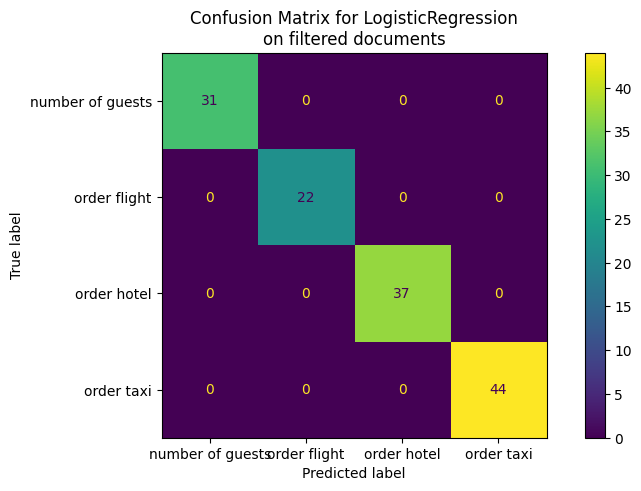

In [ ]:
# # create vector based of the features 

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(data['text'])
y = data['intent'].values

# # split to train and test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=12)

from sklearn.linear_model import LogisticRegression


# Train a logistic regression model
clf = LogisticRegression(max_iter=1000, random_state=42)
clf.fit(X_train, y_train)

pred = clf.predict(X_test)

from sklearn.metrics import ConfusionMatrixDisplay
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(10, 5))
ConfusionMatrixDisplay.from_predictions(y_test, pred, ax=ax)

_ = ax.set_title(
    f"Confusion Matrix for {clf.__class__.__name__}\non filtered documents"
)

# Creating the polarity object 

In [ ]:
!pip install spacytextblob
import spacy
from spacytextblob.spacytextblob import SpacyTextBlob
nlp = spacy.load("en_core_web_sm")
nlp.add_pipe('spacytextblob')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Using Word2vec spell check 

In [ ]:
import gensim.downloader as api
# Load the pre-trained Google News Word2Vec model
model = api.load('glove-wiki-gigaword-100')
import re

In [ ]:
def spell_check(text):
    corrected_text = []
    for word in text.split():
        if word in model:
            corrected_text.append(word)
        else:
            corrected_word = correction(word)
            corrected_text.append(corrected_word)
    return ' '.join(corrected_text)

# Probability of `word`.
def P(word):
    return - model.key_to_index.get(word, 0).index if word in model.vocab else 0

# Generate possible spelling corrections for word.
def candidates(word):
    return (known([word]) or known(edits1(word)) or known(edits2(word)) or [word])

# The subset of `words` that appear in the dictionary of WORDS.
def known(words):
    return set(w for w in words if w in model.vocab)

# All edits that are one edit away from `word`.
def edits1(word):
    letters = 'abcdefghijklmnopqrstuvwxyz'
    splits = [(word[:i], word[i:]) for i in range(len(word) + 1)]
    deletes = [L + R[1:] for L, R in splits if R]
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
    replaces = [L + c + R[1:] for L, R in splits if R for c in letters]
    inserts = [L + c + R for L, R in splits for c in letters]
    return set(deletes + transposes + replaces + inserts)

## All edits that are two edits away from `word`.
def edits2(word):
    return (e2 for e1 in edits1(word) for e2 in edits1(e1))
    
def correction(word):
    return max(candidates(word), key=P)


#Using OpenTripMap API
in order to offer attractions based on the user input 

In [ ]:
def GetRecomendedAttractions(destination):

  # Specify the API endpoint URL and parameters
  api_key = "5ae2e3f221c38a28845f05b60a50fcc28c951ccd419cde3ff204da68"

  destination = destination.replace(" ", "%20")
  destination = destination.title()
  url = f"https://api.opentripmap.com/0.1/en/places/geoname?name={destination}&apikey={api_key}"
  # Send a GET request to the API endpoint with the specified parameters
  response = requests.get(url)
  # Parse the JSON response
  data = json.loads(response.text)
  url = f"https://api.opentripmap.com/0.1/en/places/radius?radius=20000&lon={data['lon']}&lat={data['lat']}&kinds=interesting_places&format=json&limit=15&apikey={api_key}"
  data = requests.get(url).json()
  arr = []
  for site in data:
    if site["name"] !='' and len(arr) < 3:
      arr.append(site["name"])
  destination = destination.replace("%20", " ")
  print(f"This are the major attraction's in {destination}:")
  for i in range(len(arr)):
    print(f"{i+1}. {arr[i]}.")

#Chat bot implementation 

In [ ]:
def process_chat_input(user_input):
  # the default for unrecognized intent and 
  intent= -1
  # spell check the input
  text = spell_check(user_input)
  output = None

  doc = nlp(text)
  # check if there is at least one intent with probablty above 0.5
  new_text_transformed = vectorizer.transform([text])
  ans = clf.predict_proba(new_text_transformed)
  if any(x > 0.6 for x in ans[0]):
    intent = clf.predict(new_text_transformed)
  # transform the ['intent'] to 'intent'
    intent = intent[0]
  
  # get all the entities that were found in the input
  entities = {}
  for ent in doc.ents:
    entities[ent.label_] = ent.text
  global next_step
  # if there is a GPE in the input 
  if ('GPE' in entities.keys()): 
      output,next_step = next_state(intent,entities['GPE'])

  # if there isn't a GPE in the input 
  else:
      output,next_step = next_state(intent,None)
  return output,intent,next_step, doc._.blob.polarity,entities

In [ ]:
def next_state(intent,gpe):
  global option
  if intent == -1:
    return "I'm having trouble understanding your request; please be more explicit.",next_step
  elif gpe != None and intent!='number of guests' and option:
    GetRecomendedAttractions(gpe)
    
  if intent == 'order flight':
    if gpe:
      return f"Your flight to {gpe} is booked!",1
      
    else:
      return f"No problem i can order a flight for you",1

  if intent == 'order taxi':
    if gpe:
      return f"Your taxi to {gpe} is on the way to your location",2
  
    else:
      return f"No problem i can order a taxi for you",2

  if intent == 'order hotel':
    x= 'Please insert how many adults and child are will be in the room?'
    if gpe:
      return f"Your hotel in {gpe} is booked for your rqeuest. {x}",3
      
    else:
      return f"No problem i can order an hotel room for you. {x}",3

  if intent == 'number of guests':
    if gpe:
      return f"Your room hotel in {gpe} is booked for you",4
      
    else:
      return f"No problem i ordered a room hotel for you",4
        

In [ ]:
def online():
  global option
  option = 1
  next_step = 0
  intro = 'Hi! I\'m a travel chatbot, and I can help you book a flight, a taxi, or a hotel.\nPlease include the name of the relevant city destination in the request for further offering.\ninsert "exit" to quit.\n'
  print('Chatbot: ',intro)
  while True:
    user_input = input('User:')
    user_input = str.lower(user_input)
    if str.lower(user_input)=='exit':
      break
    print(process_chat_input(user_input),'\n------------------------')
  print('Thank you for using our travel bot!')

In [ ]:
import csv

def offline(file_path):
    # Open the input text file in read mode
    with open(file_path,"r") as input_file:
        # Read all lines from the file and store them as a list of strings
        user_input_lines = input_file.readlines()

    with open("output.csv", "w", newline='') as output_file:
        # Define the headers for the CSV file
        headers = ["Chatbot Answer", "Intent", "State","Polarity", "Entities"]
        # Create a CSV writer object with headers
        writer = csv.writer(output_file)
        writer.writerow(headers)

        # Loop through all the lines in the input file
        for line in user_input_lines:
            line = str.rstrip(line)
            # Process each line and get the result as a list
            result = process_chat_input(str.lower(line))
            # Write the result to the output CSV file
            writer.writerow(result)

    # Print a message to confirm that the text has been written to the file
    print("The text has been written to output.csv")


# Running the bot

## Offline state
Run the cell below and pass the path of the file as string to the function.
The result will be the file output.csv.


In [ ]:
option = 0
next_step = 0
#offline('pass the path to the file here')

## Online state
Run the cell below to begin the chat,
in order to see the use of the api in the chat there is need to put in the request the name of a city,(not all the city's are known by the api)
for example: "i need to fly to moscow" 

In [ ]:
next_step = 0
online()

Chatbot:  Hi! I'm a travel chatbot, and I can help you book a flight, a taxi, or a hotel.
Please include the name of the relevant city destination in the request for further offering.
insert "exit" to quit.

This are the major attraction's in Paris:
1. Point zéro des routes de France.
2. fontaine du Parvis Notre-Dame.
3. Galerie des Rois.
('Your flight to paris is booked!', 'order flight', 1, 0.8, {'GPE': 'paris'}) 
------------------------
